# Checking pythorh correct work

## Import and show data

In [16]:
#импортируем необходимые библиотеки

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
import onnx
import tensorflow as tf
%matplotlib inline

2023-03-05 15:50:25.604196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 15:50:26.542844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-05 15:50:26.542898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-05 15:50:26.542905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WEIGHT = 64

In [3]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("hotgot", "not_hot_dog")

#путь до датасета
PATH = "./hotdog"

In [4]:
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((IMG_HEIGHT,IMG_WEIGHT)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [5]:
next(iter(trainloader))[0].shape

torch.Size([64, 3, 64, 64])

In [6]:
next(iter(trainloader))[1]

tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

Real Labels:  not_hot_dog not_hot_dog hotgot not_hot_dog


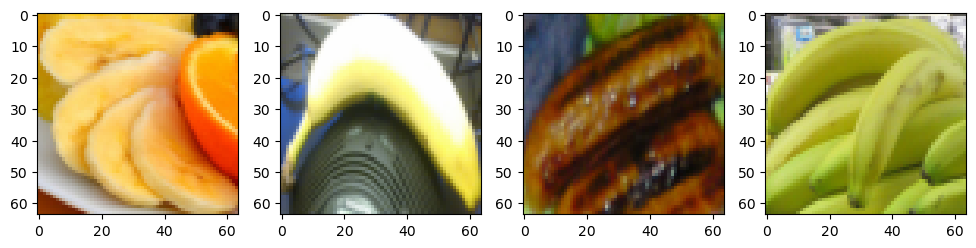

In [7]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

## Choose CUDA device

In [8]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## or switch cpu

In [9]:
# device = 'cpu'

## Build model

In [10]:
#загрузим нашу модель
# model = torchvision.models.resnet18(pretrained=True)
torch_model = torchvision.models.resnet18(weights = True)
#заморозим веса
for param in torch_model.parameters():
    param.require = False

#так как у нас 2 класса, нужно переопределить последний слой сети под нашу задачу
#у предобученной сети было на выходе 1000 классов, поэтому в видео я сказал меняем 1000 на 2
torch_model.fc = nn.Linear(512, 2)

/home/nikmih/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#Зададим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr = 0.001, momentum=0.9)

## Fit model

In [12]:
#Здесь будет тренировка нейронной сети

epochs = 3   #количество эпох (сколько раз будем тренировать)
torch_model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = torch_model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

32it [00:06,  4.68it/s]


Epoch 0 - Training loss: 0.5385408103466034 


32it [00:04,  7.44it/s]


Epoch 1 - Training loss: 0.1991256142500788 


32it [00:04,  7.54it/s]

Epoch 2 - Training loss: 0.10240658978000283 


In [13]:
list(data[0].shape)

[16, 3, 64, 64]

Accuracy: 92
Real Labels:  not_hot_dog not_hot_dog not_hot_dog hotgot
Predicted:  not_hot_dog not_hot_dog not_hot_dog hotgot


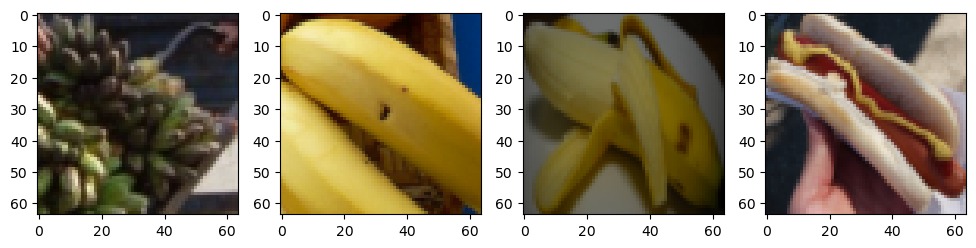

In [14]:
#посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    torch_model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = torch_model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = torch_model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))

## Save pytorch model

In [15]:
torch.save(torch_model.state_dict(), 'pytorch_weights.pth')


In [21]:
list(data[0].shape)

[32, 3, 64, 64]

In [17]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

In [18]:
# saved model to onnx format
# trained_model = torch_model()
# trained_model.load_state_dict(torch.load('pytorch_weights.pth'))
dummy_input = torch.randn(32, 3, 64, 64, device = device)
# dummy_input = torch.randn(32, 3, 64, 64, requires_grad=True)
# torch.onnx.export(trained_model, dummy_input, “your_model.onnx”)

In [19]:
torch.onnx.export(torch_model, dummy_input, "pytorch_.onnx", verbose=True, input_names=input_names, output_names=output_names)


Exported graph: graph(%actual_input_1 : Float(32, 3, 64, 64, strides=[12288, 4096, 64, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_203 : Float(64, strides=[1], requires_grad=0, device=cuda:

## Onix model download

In [20]:
# Load the ONNX model
model = onnx.load("pytorch_.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch_jit (
  %actual_input_1[FLOAT, 32x3x64x64]
) initializers (
  %fc.weight[FLOAT, 2x512]
  %fc.bias[FLOAT, 2]
  %onnx::Conv_193[FLOAT, 64x3x7x7]
  %onnx::Conv_194[FLOAT, 64]
  %onnx::Conv_196[FLOAT, 64x64x3x3]
  %onnx::Conv_197[FLOAT, 64]
  %onnx::Conv_199[FLOAT, 64x64x3x3]
  %onnx::Conv_200[FLOAT, 64]
  %onnx::Conv_202[FLOAT, 64x64x3x3]
  %onnx::Conv_203[FLOAT, 64]
  %onnx::Conv_205[FLOAT, 64x64x3x3]
  %onnx::Conv_206[FLOAT, 64]
  %onnx::Conv_208[FLOAT, 128x64x3x3]
  %onnx::Conv_209[FLOAT, 128]
  %onnx::Conv_211[FLOAT, 128x128x3x3]
  %onnx::Conv_212[FLOAT, 128]
  %onnx::Conv_214[FLOAT, 128x64x1x1]
  %onnx::Conv_215[FLOAT, 128]
  %onnx::Conv_217[FLOAT, 128x128x3x3]
  %onnx::Conv_218[FLOAT, 128]
  %onnx::Conv_220[FLOAT, 128x128x3x3]
  %onnx::Conv_221[FLOAT, 128]
  %onnx::Conv_223[FLOAT, 256x128x3x3]
  %onnx::Conv_224[FLOAT, 256]
  %onnx::Conv_226[FLOAT, 256x256x3x3]
  %onnx::Conv_227[FLOAT, 256]
  %onnx::Conv_229[FLOAT, 256x128x1x1]
  %onnx::Conv_230[FLOAT, 256]
  %onnx::Conv_

In [21]:
import onnxruntime as ort

ort_session = ort.InferenceSession("pytorch_.onnx")

outputs = ort_session.run(
    None,
    {"actual_input_1": np.random.randn(32, 3, 64, 64).astype(np.float32)},
)
print(outputs[0])

[[-1.1182077  -0.2093279 ]
 [-0.98762953 -0.20396723]
 [-0.8383671  -0.4788968 ]
 [-0.9908648  -0.24590409]
 [-1.0669531  -0.24241892]
 [-1.1627719  -0.21168458]
 [-1.3387649   0.1565022 ]
 [-1.2294824  -0.14753824]
 [-1.216012   -0.42155698]
 [-1.1460677  -0.00393765]
 [-0.94324255 -0.42611426]
 [-1.0245498  -0.2750799 ]
 [-0.9107464  -0.16290022]
 [-0.904948   -0.3410318 ]
 [-1.1980517  -0.5606464 ]
 [-1.0780799  -0.1737178 ]
 [-1.3020328  -0.49586344]
 [-1.1732054  -0.44680065]
 [-0.95232195 -0.31887567]
 [-1.4270732  -0.25787738]
 [-1.4497559  -0.27088252]
 [-0.86871386 -0.44709247]
 [-0.93632126 -0.29626894]
 [-0.977118   -0.1516983 ]
 [-1.4128985  -0.22102597]
 [-1.0502831  -0.42784905]
 [-1.6527615  -0.29658258]
 [-1.231925   -0.3833933 ]
 [-0.9880384  -0.39993078]
 [-1.2750013  -0.2559256 ]
 [-1.1503793  -0.03562414]
 [-1.0415539  -0.31600517]]


In [47]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [25]:
from pytorch2keras.converter import pytorch_to_keras


ModuleNotFoundError: No module named 'pytorch2keras'

In [56]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: next(iter(testloader))[0]}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

RuntimeError: Input must be a list of dictionaries or a single numpy array for input 'input'.

# libs Tensorflow

In [24]:
from copy import deepcopy
import keras
import tensorflow as tf

2023-03-05 15:32:32.064979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 15:32:32.801349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-05 15:32:32.801393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-05 15:32:32.801399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [25]:
# print(tf.config.list_physical_devices('GPU'))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(641.54565, shape=(), dtype=float32)


2023-03-05 15:32:35.795182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 15:32:35.795445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-05 15:32:35.795484: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-05 15:32:35.795715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D